# Import libraries

In [ ]:
import pandas as pd 
import geopandas as gpd 
import numpy as np 
import zipfile
import os
from shapely.ops import voronoi_diagram, unary_union
from shapely.geometry import MultiPoint, box
import matplotlib.pyplot as plt
from collections import defaultdict
from shapely.geometry import Point, LineString, Polygon
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from tqdm import tqdm  
start_time = time.time()

## Loading the data from all the data folders

#### POIs

In [ ]:
# Folder direction
files = "POIs"

# List to store the DataFrames
dfs = []

# Iterate above the files in the directory
for archives in os.listdir(files):
    if archives.endswith(".csv"):
        route_archives = os.path.join(files, archives)
        df = pd.read_csv(route_archives)
        dfs.append(df)

# Join all the DataFrames in one
final_POIs = pd.concat(dfs, ignore_index=True)
final_POIs.head(4)

C:\Users\52452\AppData\Local\Temp\ipykernel_9052\3319081435.py:11: DtypeWarning: Columns (9,10,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(route_archives)
C:\Users\52452\AppData\Local\Temp\ipykernel_9052\3319081435.py:11: DtypeWarning: Columns (27,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(route_archives)


,Unnamed: 0,LINK_ID,POI_ID,SEQ_NUM,FAC_TYPE,POI_NAME,POI_LANGCD,POI_NMTYPE,POI_ST_NUM,ST_NUM_FUL,...,AIRPT_TYPE,ENTR_TYPE,REST_TYPE,FOOD_TYPE,ALT_FOOD,REG_FOOD,RSTR_TYPE,OPEN_24,DIESEL,BLD_TYPE
0,244,1296526969,1244439551,1,4013,TOLUCA CENTRO,SPA,B,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,85076,702722866,1244248545,1,9535,MISCELÁNEA,SPA,B,144.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,104077,702722866,1178939983,1,9535,TIENDA DE ABARROTES,SPA,B,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,151,1296526966,1244944824,1,4013,TOLUCA CENTRO,SPA,B,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
final_POIs.shape

(193076, 40)

In [4]:
final_POIs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193076 entries, 0 to 193075
Data columns (total 40 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  193076 non-null  int64  
 1   LINK_ID     193076 non-null  int64  
 2   POI_ID      193076 non-null  int64  
 3   SEQ_NUM     193076 non-null  int64  
 4   FAC_TYPE    193076 non-null  int64  
 5   POI_NAME    193064 non-null  object 
 6   POI_LANGCD  193064 non-null  object 
 7   POI_NMTYPE  193064 non-null  object 
 8   POI_ST_NUM  28511 non-null   float64
 9   ST_NUM_FUL  2 non-null       object 
 10  ST_NFUL_LC  2 non-null       object 
 11  ST_NAME     185016 non-null  object 
 12  ST_LANGCD   185016 non-null  object 
 13  POI_ST_SD   193076 non-null  object 
 14  ACC_TYPE    0 non-null       float64
 15  PH_NUMBER   51490 non-null   object 
 16  CHAIN_ID    193076 non-null  int64  
 17  NAT_IMPORT  193076 non-null  object 
 18  PRIVATE     193076 non-null  object 
 19  IN

### Steets_Naming_Adressing

In [ ]:
# Folder direction
files = "STREETS_NAMING_ADDRESSING"

# List to store the GeoDataFrames
gdfs = []

# Iterate above the files in the directory
for archives in os.listdir(files):
    if archives.endswith(".geojson"):
        route_archives = os.path.join(files, archives)
        gdf = gpd.read_file(route_archives)
        gdfs.append(gdf)

# Join all the GeoDataFrames in one
streets_naming_final_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)
streets_naming_final_gdf.head(4)

,ADDR_TYPE,link_id,L_ADDRFORM,L_ADDRSCH,L_NREFADDR,L_REFADDR,R_ADDRFORM,R_ADDRSCH,R_NREFADDR,R_REFADDR,ST_LANGCD,ST_NAME,ST_NM_BASE,ST_NM_SUFF,ST_TYP_AFT,ST_TYP_ATT,ST_TYP_BEF,geometry
0,B,1115212395,None,None,None,None,N,E,672,30,SPA,CALLE MARIANO ZÚÑIGA,MARIANO ZÚÑIGA,None,None,N,CALLE,"LINESTRING (-99.63067 19.26921, -99.63059 19.2..."
1,B,702663287,N,E,100,132,N,O,101,125,SPA,CALLE CARLOTA,CARLOTA,None,None,N,CALLE,"LINESTRING (-99.63421 19.26966, -99.63322 19.2..."
2,None,1272517807,None,None,None,None,None,None,None,None,None,None,None,None,None,N,None,"LINESTRING (-99.6323 19.26838, -99.63215 19.26..."
3,None,1115212390,None,None,None,None,None,None,None,None,None,None,None,None,None,N,None,"LINESTRING (-99.63069 19.26954, -99.63077 19.2..."


In [6]:
streets_naming_final_gdf.shape

(760189, 18)

In [8]:
streets_naming_final_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 760189 entries, 0 to 760188
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   ADDR_TYPE   268464 non-null  object  
 1   link_id     760189 non-null  int32   
 2   L_ADDRFORM  197723 non-null  object  
 3   L_ADDRSCH   197723 non-null  object  
 4   L_NREFADDR  197723 non-null  object  
 5   L_REFADDR   197723 non-null  object  
 6   R_ADDRFORM  198010 non-null  object  
 7   R_ADDRSCH   198010 non-null  object  
 8   R_NREFADDR  198010 non-null  object  
 9   R_REFADDR   198010 non-null  object  
 10  ST_LANGCD   556910 non-null  object  
 11  ST_NAME     556910 non-null  object  
 12  ST_NM_BASE  556910 non-null  object  
 13  ST_NM_SUFF  4 non-null       object  
 14  ST_TYP_AFT  467 non-null     object  
 15  ST_TYP_ATT  760189 non-null  object  
 16  ST_TYP_BEF  430715 non-null  object  
 17  geometry    760189 non-null  geometry
dtypes: geometry(1), 

In [9]:
streets_naming_final_gdf.isna().sum() # Check for missing values

ADDR_TYPE     491725
link_id            0
L_ADDRFORM    562466
L_ADDRSCH     562466
L_NREFADDR    562466
L_REFADDR     562466
R_ADDRFORM    562179
R_ADDRSCH     562179
R_NREFADDR    562179
R_REFADDR     562179
ST_LANGCD     203279
ST_NAME       203279
ST_NM_BASE    203279
ST_NM_SUFF    760185
ST_TYP_AFT    759722
ST_TYP_ATT         0
ST_TYP_BEF    329474
geometry           0
dtype: int64

In [10]:
streets_naming_final_gdf.fillna("Unknown", inplace=True)
streets_naming_final_gdf.isna().sum() # Check for missing values

ADDR_TYPE     0
link_id       0
L_ADDRFORM    0
L_ADDRSCH     0
L_NREFADDR    0
L_REFADDR     0
R_ADDRFORM    0
R_ADDRSCH     0
R_NREFADDR    0
R_REFADDR     0
ST_LANGCD     0
ST_NAME       0
ST_NM_BASE    0
ST_NM_SUFF    0
ST_TYP_AFT    0
ST_TYP_ATT    0
ST_TYP_BEF    0
geometry      0
dtype: int64

### "STREETS_NAV"

In [ ]:
# Folder direction
files = "STREETS_NAV"

# List to store the GeoDataFrames
gdfs = []

# Iterate above the files in the directory
for archives in os.listdir(files):
    if archives.endswith(".geojson"):
        route_archives = os.path.join(files, archives)
        gdf = gpd.read_file(route_archives)
        gdfs.append(gdf)

# Join all the GeoDataFrames in one
streets_nav_final_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)
streets_nav_final_gdf.head(4)

,AR_AUTO,AR_BUS,AR_CARPOOL,AR_DELIV,AR_EMERVEH,AR_MOTOR,AR_PEDEST,AR_TAXIS,AR_TRAFF,AR_TRUCKS,...,RAMP,ROUNDABOUT,SPEED_CAT,TOLLWAY,TO_LANES,TO_SPD_LIM,TUNNEL,UNDEFTRAFF,URBAN,geometry
0,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,...,N,N,7,N,0,0,N,N,Y,"LINESTRING (-99.63067 19.26921, -99.63059 19.2..."
1,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,...,N,N,7,N,0,0,N,N,Y,"LINESTRING (-99.63421 19.26966, -99.63322 19.2..."
2,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,...,N,N,7,N,0,0,N,N,Y,"LINESTRING (-99.6323 19.26838, -99.63215 19.26..."
3,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,...,N,N,7,N,0,0,N,N,Y,"LINESTRING (-99.63069 19.26954, -99.63077 19.2..."


In [12]:
streets_nav_final_gdf.shape

(760189, 42)

In [13]:
streets_nav_final_gdf.isna().sum() # Check for missing values

AR_AUTO       0
AR_BUS        0
AR_CARPOOL    0
AR_DELIV      0
AR_EMERVEH    0
AR_MOTOR      0
AR_PEDEST     0
AR_TAXIS      0
AR_TRAFF      0
AR_TRUCKS     0
BRIDGE        0
CONTRACC      0
COVERIND      0
DIR_TRAVEL    0
DIVIDER       0
FERRY_TYPE    0
FROM_LANES    0
FRONTAGE      0
FR_SPD_LIM    0
FUNC_CLASS    0
INDESCRIB     0
INTERINTER    0
LANE_CAT      0
link_id       0
LOW_MBLTY     0
MANOEUVRE     0
MULTIDIGIT    0
PAVED         0
POIACCESS     0
PRIORITYRD    0
PRIVATE       0
PUB_ACCESS    0
RAMP          0
ROUNDABOUT    0
SPEED_CAT     0
TOLLWAY       0
TO_LANES      0
TO_SPD_LIM    0
TUNNEL        0
UNDEFTRAFF    0
URBAN         0
geometry      0
dtype: int64

## Join both "STREETS" gdfs

In [14]:
# Making sure is the same CRS
streets_nav_final_gdf = streets_nav_final_gdf.to_crs(streets_naming_final_gdf.crs)

# Convert the geometry to text (WKT) for an exact match
streets_nav_final_gdf['geom_wkt'] = streets_nav_final_gdf.geometry.apply(lambda g: g.wkt)
streets_naming_final_gdf['geom_wkt'] = streets_naming_final_gdf.geometry.apply(lambda g: g.wkt)

# Use merge to combine the two GeoDataFrames based on the WKT representation of the geometries
streets_gdf_merged = streets_nav_final_gdf.merge(streets_naming_final_gdf, on='geom_wkt', how='inner')  # 'inner' para solo coincidencias exactas

In [16]:
streets_gdf_merged.head(4)

,AR_AUTO,AR_BUS,AR_CARPOOL,AR_DELIV,AR_EMERVEH,AR_MOTOR,AR_PEDEST,AR_TAXIS,AR_TRAFF,AR_TRUCKS,...,R_NREFADDR,R_REFADDR,ST_LANGCD,ST_NAME,ST_NM_BASE,ST_NM_SUFF,ST_TYP_AFT,ST_TYP_ATT,ST_TYP_BEF,geometry_y
0,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,...,672,30,SPA,CALLE MARIANO ZÚÑIGA,MARIANO ZÚÑIGA,Unknown,Unknown,N,CALLE,"LINESTRING (-99.63067 19.26921, -99.63059 19.2..."
1,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,...,101,125,SPA,CALLE CARLOTA,CARLOTA,Unknown,Unknown,N,CALLE,"LINESTRING (-99.63421 19.26966, -99.63322 19.2..."
2,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,N,Unknown,"LINESTRING (-99.6323 19.26838, -99.63215 19.26..."
3,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,N,Unknown,"LINESTRING (-99.63069 19.26954, -99.63077 19.2..."


In [17]:
streets_gdf_merged.shape

(761007, 61)

In [18]:
streets_gdf_merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 761007 entries, 0 to 761006
Data columns (total 61 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   AR_AUTO     761007 non-null  object  
 1   AR_BUS      761007 non-null  object  
 2   AR_CARPOOL  761007 non-null  object  
 3   AR_DELIV    761007 non-null  object  
 4   AR_EMERVEH  761007 non-null  object  
 5   AR_MOTOR    761007 non-null  object  
 6   AR_PEDEST   761007 non-null  object  
 7   AR_TAXIS    761007 non-null  object  
 8   AR_TRAFF    761007 non-null  object  
 9   AR_TRUCKS   761007 non-null  object  
 10  BRIDGE      761007 non-null  object  
 11  CONTRACC    761007 non-null  object  
 12  COVERIND    761007 non-null  object  
 13  DIR_TRAVEL  761007 non-null  object  
 14  DIVIDER     761007 non-null  object  
 15  FERRY_TYPE  761007 non-null  object  
 16  FROM_LANES  761007 non-null  int32   
 17  FRONTAGE    761007 non-null  object  
 18  FR_SPD_LIM  7610

In [19]:
streets_gdf_merged.columns.tolist()

['AR_AUTO',
 'AR_BUS',
 'AR_CARPOOL',
 'AR_DELIV',
 'AR_EMERVEH',
 'AR_MOTOR',
 'AR_PEDEST',
 'AR_TAXIS',
 'AR_TRAFF',
 'AR_TRUCKS',
 'BRIDGE',
 'CONTRACC',
 'COVERIND',
 'DIR_TRAVEL',
 'DIVIDER',
 'FERRY_TYPE',
 'FROM_LANES',
 'FRONTAGE',
 'FR_SPD_LIM',
 'FUNC_CLASS',
 'INDESCRIB',
 'INTERINTER',
 'LANE_CAT',
 'link_id_x',
 'LOW_MBLTY',
 'MANOEUVRE',
 'MULTIDIGIT',
 'PAVED',
 'POIACCESS',
 'PRIORITYRD',
 'PRIVATE',
 'PUB_ACCESS',
 'RAMP',
 'ROUNDABOUT',
 'SPEED_CAT',
 'TOLLWAY',
 'TO_LANES',
 'TO_SPD_LIM',
 'TUNNEL',
 'UNDEFTRAFF',
 'URBAN',
 'geometry_x',
 'geom_wkt',
 'ADDR_TYPE',
 'link_id_y',
 'L_ADDRFORM',
 'L_ADDRSCH',
 'L_NREFADDR',
 'L_REFADDR',
 'R_ADDRFORM',
 'R_ADDRSCH',
 'R_NREFADDR',
 'R_REFADDR',
 'ST_LANGCD',
 'ST_NAME',
 'ST_NM_BASE',
 'ST_NM_SUFF',
 'ST_TYP_AFT',
 'ST_TYP_ATT',
 'ST_TYP_BEF',
 'geometry_y']

In [20]:
streets_subset = streets_gdf_merged[["geometry_x", "geometry_y"]]

In [21]:
streets_subset.head(4)

,geometry_x,geometry_y
0,"LINESTRING (-99.63067 19.26921, -99.63059 19.2...","LINESTRING (-99.63067 19.26921, -99.63059 19.2..."
1,"LINESTRING (-99.63421 19.26966, -99.63322 19.2...","LINESTRING (-99.63421 19.26966, -99.63322 19.2..."
2,"LINESTRING (-99.6323 19.26838, -99.63215 19.26...","LINESTRING (-99.6323 19.26838, -99.63215 19.26..."
3,"LINESTRING (-99.63069 19.26954, -99.63077 19.2...","LINESTRING (-99.63069 19.26954, -99.63077 19.2..."


Both columns have the same information so we only keep one.

##### Check for duplicated data

In [23]:
duplicated = streets_gdf_merged[streets_gdf_merged.duplicated()]
duplicated.head()

,AR_AUTO,AR_BUS,AR_CARPOOL,AR_DELIV,AR_EMERVEH,AR_MOTOR,AR_PEDEST,AR_TAXIS,AR_TRAFF,AR_TRUCKS,...,R_NREFADDR,R_REFADDR,ST_LANGCD,ST_NAME,ST_NM_BASE,ST_NM_SUFF,ST_TYP_AFT,ST_TYP_ATT,ST_TYP_BEF,geometry_y


In [ ]:
# We only need one id_link column
streets_gdf_merged.drop(columns=['link_id_x'], inplace=True)
streets_gdf_merged.rename(columns={'link_id_y': 'LINK_ID'}, inplace=True)
# streets_gdf_merged.head(4)

In [ ]:
streets_gdf_merged.drop(columns=['geometry_x'], inplace=True)
streets_gdf_merged.rename(columns={'geometry_y': 'geometry_street'}, inplace=True)
# streets_gdf_merged.head(4)

#### Import result

In [ ]:
streets_gdf_merged.to_file(
    "complete_streets.geojson",
    driver='GeoJSON'
)

In [27]:
streets_gdf_merged.columns.tolist()

['AR_AUTO',
 'AR_BUS',
 'AR_CARPOOL',
 'AR_DELIV',
 'AR_EMERVEH',
 'AR_MOTOR',
 'AR_PEDEST',
 'AR_TAXIS',
 'AR_TRAFF',
 'AR_TRUCKS',
 'BRIDGE',
 'CONTRACC',
 'COVERIND',
 'DIR_TRAVEL',
 'DIVIDER',
 'FERRY_TYPE',
 'FROM_LANES',
 'FRONTAGE',
 'FR_SPD_LIM',
 'FUNC_CLASS',
 'INDESCRIB',
 'INTERINTER',
 'LANE_CAT',
 'LOW_MBLTY',
 'MANOEUVRE',
 'MULTIDIGIT',
 'PAVED',
 'POIACCESS',
 'PRIORITYRD',
 'PRIVATE',
 'PUB_ACCESS',
 'RAMP',
 'ROUNDABOUT',
 'SPEED_CAT',
 'TOLLWAY',
 'TO_LANES',
 'TO_SPD_LIM',
 'TUNNEL',
 'UNDEFTRAFF',
 'URBAN',
 'geom_wkt',
 'ADDR_TYPE',
 'LINK_ID',
 'L_ADDRFORM',
 'L_ADDRSCH',
 'L_NREFADDR',
 'L_REFADDR',
 'R_ADDRFORM',
 'R_ADDRSCH',
 'R_NREFADDR',
 'R_REFADDR',
 'ST_LANGCD',
 'ST_NAME',
 'ST_NM_BASE',
 'ST_NM_SUFF',
 'ST_TYP_AFT',
 'ST_TYP_ATT',
 'ST_TYP_BEF',
 'geometry_street']

### Identifying POIs on streets making them a geometry

#### Derivated geometry for POIs

In [28]:
# link_id merge 
final_POIs = final_POIs.merge(
    streets_gdf_merged,
    on='LINK_ID',
    how='left'
)


In [29]:
final_POIs.head(4)

,Unnamed: 0,LINK_ID,POI_ID,SEQ_NUM,FAC_TYPE,POI_NAME,POI_LANGCD,POI_NMTYPE,POI_ST_NUM,ST_NUM_FUL,...,R_NREFADDR,R_REFADDR,ST_LANGCD_y,ST_NAME_y,ST_NM_BASE,ST_NM_SUFF,ST_TYP_AFT,ST_TYP_ATT,ST_TYP_BEF,geometry_street
0,244,1296526969,1244439551,1,4013,TOLUCA CENTRO,SPA,B,NaN,NaN,...,Unknown,Unknown,SPA,AVENIDA SOLIDARIDAD LAS TORRES,SOLIDARIDAD LAS TORRES,Unknown,Unknown,N,AVENIDA,"LINESTRING (-99.6423 19.2704, -99.6418 19.27052)"
1,85076,702722866,1244248545,1,9535,MISCELÁNEA,SPA,B,144.0,NaN,...,Unknown,Unknown,SPA,CALLE GLORIA,GLORIA,Unknown,Unknown,N,CALLE,"LINESTRING (-99.63501 19.27018, -99.63419 19.2..."
2,104077,702722866,1178939983,1,9535,TIENDA DE ABARROTES,SPA,B,NaN,NaN,...,Unknown,Unknown,SPA,CALLE GLORIA,GLORIA,Unknown,Unknown,N,CALLE,"LINESTRING (-99.63501 19.27018, -99.63419 19.2..."
3,151,1296526966,1244944824,1,4013,TOLUCA CENTRO,SPA,B,NaN,NaN,...,Unknown,Unknown,SPA,AVENIDA SOLIDARIDAD LAS TORRES,SOLIDARIDAD LAS TORRES,Unknown,Unknown,N,AVENIDA,"LINESTRING (-99.64108 19.2704, -99.6404 19.27056)"


In [30]:
final_POIs.shape

(194225, 98)

In [ ]:
# Creating geometries for POIs (midpoint of the linestring)
def get_midpoint(linestring):
    if pd.isna(linestring):
        return None
    return linestring.interpolate(0.5, normalized=True)

final_POIs['geometry'] = final_POIs['geometry_street'].apply(get_midpoint)

# Filtering POIs without geometry (No ID_LINK matched)
pois_without_geometry = final_POIs[final_POIs['geometry'].isna()]
print(f"POIs sin geometría asignada: {len(pois_without_geometry)}")

POIs sin geometría asignada: 0


In [34]:
final_POIs.columns.tolist()

['Unnamed: 0',
 'LINK_ID',
 'POI_ID',
 'SEQ_NUM',
 'FAC_TYPE',
 'POI_NAME',
 'POI_LANGCD',
 'POI_NMTYPE',
 'POI_ST_NUM',
 'ST_NUM_FUL',
 'ST_NFUL_LC',
 'ST_NAME_x',
 'ST_LANGCD_x',
 'POI_ST_SD',
 'ACC_TYPE',
 'PH_NUMBER',
 'CHAIN_ID',
 'NAT_IMPORT',
 'PRIVATE_x',
 'IN_VICIN',
 'NUM_PARENT',
 'NUM_CHILD',
 'PERCFRREF',
 'VANCITY_ID',
 'ACT_ADDR',
 'ACT_LANGCD',
 'ACT_ST_NAM',
 'ACT_ST_NUM',
 'ACT_ADMIN',
 'ACT_POSTAL',
 'AIRPT_TYPE',
 'ENTR_TYPE',
 'REST_TYPE',
 'FOOD_TYPE',
 'ALT_FOOD',
 'REG_FOOD',
 'RSTR_TYPE',
 'OPEN_24',
 'DIESEL',
 'BLD_TYPE',
 'AR_AUTO',
 'AR_BUS',
 'AR_CARPOOL',
 'AR_DELIV',
 'AR_EMERVEH',
 'AR_MOTOR',
 'AR_PEDEST',
 'AR_TAXIS',
 'AR_TRAFF',
 'AR_TRUCKS',
 'BRIDGE',
 'CONTRACC',
 'COVERIND',
 'DIR_TRAVEL',
 'DIVIDER',
 'FERRY_TYPE',
 'FROM_LANES',
 'FRONTAGE',
 'FR_SPD_LIM',
 'FUNC_CLASS',
 'INDESCRIB',
 'INTERINTER',
 'LANE_CAT',
 'LOW_MBLTY',
 'MANOEUVRE',
 'MULTIDIGIT',
 'PAVED',
 'POIACCESS',
 'PRIORITYRD',
 'PRIVATE_y',
 'PUB_ACCESS',
 'RAMP',
 'ROUNDABOUT'

#### Check for duplicated data

In [35]:
duplicated = final_POIs[final_POIs.duplicated()]
duplicated.head()

,Unnamed: 0,LINK_ID,POI_ID,SEQ_NUM,FAC_TYPE,POI_NAME,POI_LANGCD,POI_NMTYPE,POI_ST_NUM,ST_NUM_FUL,...,R_REFADDR,ST_LANGCD_y,ST_NAME_y,ST_NM_BASE,ST_NM_SUFF,ST_TYP_AFT,ST_TYP_ATT,ST_TYP_BEF,geometry_street,geometry
193558,115390,979783732,1149052139,1,9565,FARMACIA SAN CHARBEL,SPA,B,NaN,NaN,...,95,SPA,AVENIDA RANCHO SIERRA HERMOSA,RANCHO SIERRA HERMOSA,Unknown,Unknown,N,AVENIDA,"LINESTRING (-98.99137 19.68715, -98.99192 19.6...",POINT (-98.99164300000001 19.687325)
193559,115390,979783732,1149052139,1,9565,FARMACIA SAN CHARBEL,SPA,B,NaN,NaN,...,95,SPA,AVENIDA RANCHO SIERRA HERMOSA,RANCHO SIERRA HERMOSA,Unknown,Unknown,N,AVENIDA,"LINESTRING (-98.99192 19.6875, -98.99215 19.68...",POINT (-98.99203299999999 19.687575000000002)


In [36]:
duplicated.shape

(2, 99)

In [ ]:
# Groping columns by base name
column_groups = defaultdict(list)

for col in final_POIs.columns:
    if '_' in col:
        base_name = col.split('_')[0] if not col.endswith(('_x', '_y', '_poi', '_street')) else col.rsplit('_', 1)[0]
        column_groups[base_name].append(col)
    else:
        column_groups[col].append(col)

# Showing the groups
for base, cols in column_groups.items():
    if len(cols) > 1 and not any(x in base for x in ['Unnamed', 'LINK', 'POI']):
        print(f"\nGrupo: {base}")
        print(cols)


Grupo: ST
['ST_NUM_FUL', 'ST_NFUL_LC', 'ST_NM_BASE', 'ST_NM_SUFF', 'ST_TYP_AFT', 'ST_TYP_ATT', 'ST_TYP_BEF']

Grupo: ST_NAME
['ST_NAME_x', 'ST_NAME_y']

Grupo: ST_LANGCD
['ST_LANGCD_x', 'ST_LANGCD_y']

Grupo: PRIVATE
['PRIVATE_x', 'PRIVATE_y']

Grupo: NUM
['NUM_PARENT', 'NUM_CHILD']

Grupo: ACT
['ACT_ADDR', 'ACT_LANGCD', 'ACT_ST_NAM', 'ACT_ST_NUM', 'ACT_ADMIN', 'ACT_POSTAL']

Grupo: AR
['AR_AUTO', 'AR_BUS', 'AR_CARPOOL', 'AR_DELIV', 'AR_EMERVEH', 'AR_MOTOR', 'AR_PEDEST', 'AR_TAXIS', 'AR_TRAFF', 'AR_TRUCKS']

Grupo: TO
['TO_LANES', 'TO_SPD_LIM']

Grupo: L
['L_ADDRFORM', 'L_ADDRSCH', 'L_NREFADDR', 'L_REFADDR']

Grupo: R
['R_ADDRFORM', 'R_ADDRSCH', 'R_NREFADDR', 'R_REFADDR']

Grupo: geometry
['geometry_street', 'geometry']


In [ ]:
def clean_merged_pois(gdf):
    # Delete unnecessary columns
    gdf = gdf.drop(columns=['Unnamed: 0', 'geom_wkt', 'geom_wkt_poi', 'geom_wkt_street'], errors='ignore')
    
    # POI attributes
    poi_attributes = ['POI_NAME', 'FAC_TYPE', 'POI_LANGCD', 'POI_NMTYPE', 
                    'POI_ST_NUM', 'ST_NUM_FUL', 'ST_NFUL_LC', 'POI_ST_SD',
                    'ACC_TYPE', 'PH_NUMBER', 'CHAIN_ID', 'NAT_IMPORT']
    
    for attr in poi_attributes:
        cols = [c for c in gdf.columns if c.startswith(attr)]
        if len(cols) > 1:
            # _poi > without suffix > _street
            if any(c.endswith('_poi') for c in cols):
                gdf[attr] = gdf[[c for c in cols if c.endswith('_poi')][0]]
            elif attr in cols:
                gdf[attr] = gdf[attr]
            else:
                gdf[attr] = gdf[cols[0]]
            gdf = gdf.drop(columns=cols)
    
    # Street attributes
    street_attributes = ['ST_NAME', 'ST_LANGCD', 'FUNC_CLASS', 'DIR_TRAVEL',
                        'FROM_LANES', 'TO_LANES', 'FR_SPD_LIM', 'TO_SPD_LIM']
    
    for attr in street_attributes:
        cols = [c for c in gdf.columns if c.startswith(attr)]
        if len(cols) > 1:
            # _street > without suffix > _poi
            if any(c.endswith('_street') for c in cols):
                gdf[attr] = gdf[[c for c in cols if c.endswith('_street')][0]]
            elif attr in cols:
                gdf[attr] = gdf[attr]
            else:
                gdf[attr] = gdf[cols[0]]
            gdf = gdf.drop(columns=cols)
    
    # Combine the access attributes logically
    access_attributes = ['AR_AUTO', 'AR_BUS', 'AR_PEDEST', 'PRIVATE', 'PUB_ACCESS']
    
    for attr in access_attributes:
        cols = [c for c in gdf.columns if c.startswith(attr) and c != attr]
        if len(cols) == 2:  # _poi y _street
            gdf[attr] = gdf[cols[0]].combine_first(gdf[cols[1]])
            gdf = gdf.drop(columns=cols)
    
    
    

    # Deleting remaining duplicate columns with suffixes _x and _y
    for col in gdf.columns:
        if col.endswith(('_x', '_y')):
            base_col = col[:-2]
            if base_col in gdf.columns:
                gdf = gdf.drop(columns=[col])
    
    return gdf

# Cleaning the merged POIs
final_POIs_clean = clean_merged_pois(final_POIs)

In [39]:
final_POIs_clean.head(4)

,LINK_ID,POI_ID,SEQ_NUM,FAC_TYPE,POI_NAME,POI_LANGCD,POI_NMTYPE,POI_ST_NUM,ST_NUM_FUL,ST_NFUL_LC,...,ST_NM_BASE,ST_NM_SUFF,ST_TYP_AFT,ST_TYP_ATT,ST_TYP_BEF,geometry_street,geometry,ST_NAME,ST_LANGCD,PRIVATE
0,1296526969,1244439551,1,4013,TOLUCA CENTRO,SPA,B,NaN,NaN,NaN,...,SOLIDARIDAD LAS TORRES,Unknown,Unknown,N,AVENIDA,"LINESTRING (-99.6423 19.2704, -99.6418 19.27052)",POINT (-99.64205000000001 19.27046),AVENIDA SOLIDARIDAD LAS TORRES,SPA,N
1,702722866,1244248545,1,9535,MISCELÁNEA,SPA,B,144.0,NaN,NaN,...,GLORIA,Unknown,Unknown,N,CALLE,"LINESTRING (-99.63501 19.27018, -99.63419 19.2...",POINT (-99.6346 19.270580000000002),CALLE GLORIA,SPA,N
2,702722866,1178939983,1,9535,TIENDA DE ABARROTES,SPA,B,NaN,NaN,NaN,...,GLORIA,Unknown,Unknown,N,CALLE,"LINESTRING (-99.63501 19.27018, -99.63419 19.2...",POINT (-99.6346 19.270580000000002),CALLE GLORIA,SPA,N
3,1296526966,1244944824,1,4013,TOLUCA CENTRO,SPA,B,NaN,NaN,NaN,...,SOLIDARIDAD LAS TORRES,Unknown,Unknown,N,AVENIDA,"LINESTRING (-99.64108 19.2704, -99.6404 19.27056)",POINT (-99.64074 19.27048),AVENIDA SOLIDARIDAD LAS TORRES,SPA,N


In [41]:
final_POIs_clean.shape

(194225, 94)

## Generating the bboxs

In [52]:
# Ensure we're working with a proper GeoDataFrame
gdf = final_POIs_clean.copy()
gdf = gdf.set_geometry('geometry')  # Set POI points as primary geometry

In [53]:
gdf.columns.tolist()

['LINK_ID',
 'POI_ID',
 'SEQ_NUM',
 'FAC_TYPE',
 'POI_NAME',
 'POI_LANGCD',
 'POI_NMTYPE',
 'POI_ST_NUM',
 'ST_NUM_FUL',
 'ST_NFUL_LC',
 'POI_ST_SD',
 'ACC_TYPE',
 'PH_NUMBER',
 'CHAIN_ID',
 'NAT_IMPORT',
 'IN_VICIN',
 'NUM_PARENT',
 'NUM_CHILD',
 'PERCFRREF',
 'VANCITY_ID',
 'ACT_ADDR',
 'ACT_LANGCD',
 'ACT_ST_NAM',
 'ACT_ST_NUM',
 'ACT_ADMIN',
 'ACT_POSTAL',
 'AIRPT_TYPE',
 'ENTR_TYPE',
 'REST_TYPE',
 'FOOD_TYPE',
 'ALT_FOOD',
 'REG_FOOD',
 'RSTR_TYPE',
 'OPEN_24',
 'DIESEL',
 'BLD_TYPE',
 'AR_AUTO',
 'AR_BUS',
 'AR_CARPOOL',
 'AR_DELIV',
 'AR_EMERVEH',
 'AR_MOTOR',
 'AR_PEDEST',
 'AR_TAXIS',
 'AR_TRAFF',
 'AR_TRUCKS',
 'BRIDGE',
 'CONTRACC',
 'COVERIND',
 'DIR_TRAVEL',
 'DIVIDER',
 'FERRY_TYPE',
 'FROM_LANES',
 'FRONTAGE',
 'FR_SPD_LIM',
 'FUNC_CLASS',
 'INDESCRIB',
 'INTERINTER',
 'LANE_CAT',
 'LOW_MBLTY',
 'MANOEUVRE',
 'MULTIDIGIT',
 'PAVED',
 'POIACCESS',
 'PRIORITYRD',
 'PUB_ACCESS',
 'RAMP',
 'ROUNDABOUT',
 'SPEED_CAT',
 'TOLLWAY',
 'TO_LANES',
 'TO_SPD_LIM',
 'TUNNEL',
 'UNDE

In [55]:
gdf = gpd.GeoDataFrame(final_POIs_clean, geometry='geometry', crs = 4326)  # Set the CRS to WGS84 (EPSG:4326)

In [56]:
print(gdf.crs)  # Check the CRS of the GeoDataFrame

EPSG:4326


In [57]:
# Create a bounding box slightly larger than your street network extent
bbox = gdf.set_geometry('geometry_street').total_bounds  # Using POis geometries
buffer_distance = 0.01   # ~1km in degrees (adjust based on your CRS)

boundary = box(bbox[0]-buffer_distance, 
               bbox[1]-buffer_distance,
               bbox[2]+buffer_distance,
               bbox[3]+buffer_distance)

## Generating Voronoi Polygons

In [59]:
# Create Voronoi diagram from POI points
points = MultiPoint(gdf.geometry.tolist())
voronoi = voronoi_diagram(points)

# Convert to GeoDataFrame
voronoi_gdf = gpd.GeoDataFrame(geometry=list(voronoi.geoms), crs=gdf.crs)

# Clip with bounding box
voronoi_clipped = gpd.clip(voronoi_gdf, boundary)

C:\Users\52452\AppData\Local\Temp\ipykernel_9052\2576679754.py:13: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


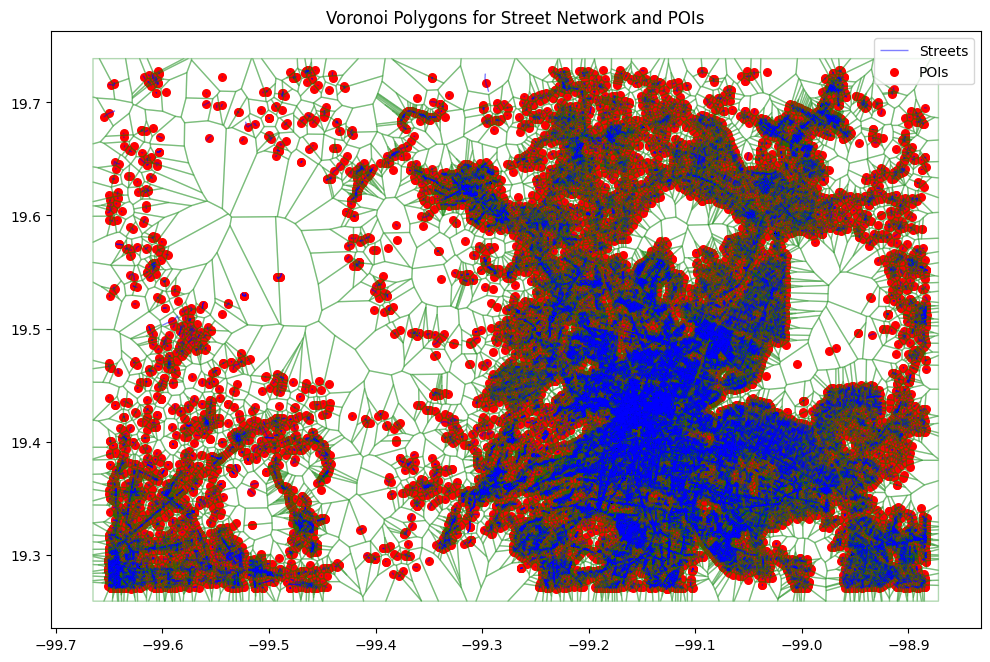

In [60]:
fig, ax = plt.subplots(figsize=(12, 10))

# Plot streets
gdf.set_geometry("geometry_street").plot(ax=ax, color='blue', linewidth=1, alpha=0.5, label='Streets')

# Plot POIs
gdf.plot(ax=ax, color='red', markersize=30, label='POIs')

# Plot Voronoi polygons
voronoi_clipped.plot(ax=ax, color='none', edgecolor='green', alpha=0.3, label='Voronoi Cells')

plt.title('Voronoi Polygons for Street Network and POIs')
plt.legend()
plt.show()

In [61]:
# Spatial join to assign each POI to its Voronoi cell
pois_with_voronoi = gpd.sjoin(gdf, voronoi_clipped, how='left', predicate='within')

# Count POIs per Voronoi cell
pois_per_cell = pois_with_voronoi.groupby('index_right').size()
pois_per_cell

index_right
0        1
1        1
2        1
3        1
4        7
        ..
92146    1
92147    2
92148    1
92149    2
92150    1
Length: 92151, dtype: int64

In [62]:
# Check for empty geometries
print("Empty Voronoi cells:", voronoi_clipped[voronoi_clipped.is_empty].shape[0])

# Check CRS consistency
assert gdf.crs == voronoi_clipped.crs, "CRS mismatch between POIs and Voronoi"

# Validate POI assignment
unassigned = pois_with_voronoi[pois_with_voronoi['index_right'].isna()]
print(f"POIs not assigned to any Voronoi cell: {len(unassigned)}")

Empty Voronoi cells: 0
POIs not assigned to any Voronoi cell: 0


In [63]:
voronoi_clipped.head(4)

,geometry
14559,"POLYGON ((-99.2349 19.26314, -99.23435 19.2677..."
13840,"POLYGON ((-99.24323 19.27357, -99.24281 19.273..."
13863,"POLYGON ((-99.23947 19.27144, -99.2383 19.2712..."
13864,"POLYGON ((-99.24104 19.2709, -99.23947 19.2729..."


In [64]:
pois_with_voronoi.head(4)

,LINK_ID,POI_ID,SEQ_NUM,FAC_TYPE,POI_NAME,POI_LANGCD,POI_NMTYPE,POI_ST_NUM,ST_NUM_FUL,ST_NFUL_LC,...,ST_NM_SUFF,ST_TYP_AFT,ST_TYP_ATT,ST_TYP_BEF,geometry_street,geometry,ST_NAME,ST_LANGCD,PRIVATE,index_right
0,1296526969,1244439551,1,4013,TOLUCA CENTRO,SPA,B,NaN,NaN,NaN,...,Unknown,Unknown,N,AVENIDA,"LINESTRING (-99.6423 19.2704, -99.6418 19.27052)",POINT (-99.64205 19.27046),AVENIDA SOLIDARIDAD LAS TORRES,SPA,N,760
1,702722866,1244248545,1,9535,MISCELÁNEA,SPA,B,144.0,NaN,NaN,...,Unknown,Unknown,N,CALLE,"LINESTRING (-99.63501 19.27018, -99.63419 19.2...",POINT (-99.6346 19.27058),CALLE GLORIA,SPA,N,1168
2,702722866,1178939983,1,9535,TIENDA DE ABARROTES,SPA,B,NaN,NaN,NaN,...,Unknown,Unknown,N,CALLE,"LINESTRING (-99.63501 19.27018, -99.63419 19.2...",POINT (-99.6346 19.27058),CALLE GLORIA,SPA,N,1168
3,1296526966,1244944824,1,4013,TOLUCA CENTRO,SPA,B,NaN,NaN,NaN,...,Unknown,Unknown,N,AVENIDA,"LINESTRING (-99.64108 19.2704, -99.6404 19.27056)",POINT (-99.64074 19.27048),AVENIDA SOLIDARIDAD LAS TORRES,SPA,N,805


In [66]:
final_pois_with_voronoi = pois_with_voronoi.copy()

In [67]:
final_pois_with_voronoi.drop(columns=['geometry_street'], inplace=True)

In [73]:
final_geometry_street = pois_with_voronoi.copy()
final_geometry_street.drop(columns=['geometry'], inplace=True)

### Downloading the results

In [ ]:
# Save Voronoi polygons
voronoi_clipped.to_file('street_voronoi_polygons.geojson', driver='GeoJSON')

# Save POIs with Voronoi information
final_pois_with_voronoi.to_file('pois_with_voronoi_cells.geojson', driver='GeoJSON')


In [74]:
# Save POIs with street geometry
final_geometry_street.to_file('pois_with_street_geometry.geojson', driver='GeoJSON')